# Spam Filter Replication of Ruskanda, F.Z., 2019

### Initialization


In [53]:
from pandas import DataFrame
import pandas as pd

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)


def get_unique_values(df: DataFrame):
    return {column: set(df[column].unique()) for column in df}

### Load Data


In [54]:
df = pd.read_csv("sms.csv")

df.head()

,Unnamed: 0,sms,spam,Unnamed: 3
0,0,1. Tension face 2. Smiling face 3. Waste face ...,False,NaN
1,1,Hhahhaahahah rofl was leonardo in your room or...,False,NaN
2,4,Oh for sake she's in like,False,NaN
3,5,No da:)he is stupid da..always sending like th...,False,NaN
4,6,Lul im gettin some juicy gossip at the hospita...,False,NaN


In [55]:
import pandas as pd

# Define the column names
column_names = ["index", "sms", "is_spam", "extra"]

# Load the data into a pandas DataFrame
# Assuming the extra comma at the end of each line results in an additional empty column, which we'll ignore
df = pd.read_csv(
    "sms.csv", names=column_names, usecols=["sms", "is_spam"], skiprows=1
)
data = df.copy()
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sms      5351 non-null   object
 1   is_spam  5351 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 47.2+ KB
None
                                                 sms  is_spam
0  1. Tension face 2. Smiling face 3. Waste face ...    False
1  Hhahhaahahah rofl was leonardo in your room or...    False
2                        Oh for  sake she's in like     False
3  No da:)he is stupid da..always sending like th...    False
4  Lul im gettin some juicy gossip at the hospita...    False


In [56]:
unique_values = get_unique_values(data)
print(len(unique_values["is_spam"]) == 2)

True


In [57]:
# Convert 'is_spam' from string 'FALSE'/'TRUE' to actual Boolean values
data["is_spam"] = (
    data["is_spam"]
    .mask(data["is_spam"] == "TRUE", True)
    .mask(data["is_spam"] == "FALSE", False)
)
data = data.convert_dtypes()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sms      5351 non-null   string 
 1   is_spam  5351 non-null   boolean
dtypes: boolean(1), string(1)
memory usage: 52.4 KB


In [58]:
# Inspect the first few rows of the DataFrame
print("First few entries of the data:")
print(data.head())

First few entries of the data:
                                                 sms  is_spam
0  1. Tension face 2. Smiling face 3. Waste face ...    False
1  Hhahhaahahah rofl was leonardo in your room or...    False
2                        Oh for  sake she's in like     False
3  No da:)he is stupid da..always sending like th...    False
4  Lul im gettin some juicy gossip at the hospita...    False


In [59]:
# Check and print data types
print("\nData types of columns:")
print(data.dtypes)


Data types of columns:
sms        string[python]
is_spam           boolean
dtype: object


In [60]:
# Check for any missing or null values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
sms        0
is_spam    0
dtype: int64


In [61]:
# Reset the DataFrame index if it's incomplete or has gaps
data.reset_index(drop=True, inplace=True)

In [62]:
# Perform initial data quality inspection
# For example, checking for duplicate entries
duplicate_rows = data.duplicated()
print("\nDuplicate rows:")
print(duplicate_rows.sum())
print("Bias in duplication:")
print("Marked as spam", len(data[duplicate_rows][data["is_spam"]]))

print("Marked as not spam", len(data[duplicate_rows][~data["is_spam"]]))


Duplicate rows:
403
Bias in duplication:
Marked as spam 102
Marked as not spam 301


/var/folders/53/5bkhp7ns2pzfq1mljpn8txrw0000gn/T/ipykernel_74281/446790045.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Marked as spam", len(data[duplicate_rows][data["is_spam"]]))
/var/folders/53/5bkhp7ns2pzfq1mljpn8txrw0000gn/T/ipykernel_74281/446790045.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Marked as not spam", len(data[duplicate_rows][~data["is_spam"]]))


As we can see there is a small sample of spam marked messages. Only 13% of our sample is marked as spam (704 messages)


In [63]:
# Display the cleaned DataFrame information
print("\nCleaned data information:")
print(data.info())


Cleaned data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sms      5351 non-null   string 
 1   is_spam  5351 non-null   boolean
dtypes: boolean(1), string(1)
memory usage: 52.4 KB
None


In [64]:
# Show cleaned data preview
print("\nCleaned data preview:")
print(data.head())


Cleaned data preview:
                                                 sms  is_spam
0  1. Tension face 2. Smiling face 3. Waste face ...    False
1  Hhahhaahahah rofl was leonardo in your room or...    False
2                        Oh for  sake she's in like     False
3  No da:)he is stupid da..always sending like th...    False
4  Lul im gettin some juicy gossip at the hospita...    False


## Methodology

Based on Ruskanda (2019) I will be attempting to implement two machine learning approaches to address the case study problem using:

1. **Naive Bayes Classifier**
   - **Rationale**: Naive Bayes is a probabilistic classifier that works well for text classification tasks, especially for spam detection. It performs well even with small datasets and handles text data's high-dimensional feature space efficiently.
   - **Advantages**: Simple and fast, performs particularly well on textual data, handles noise well, and doesn't require a large amount of training data to produce effective classifications.
   - **Implementation**: In Python, the Scikit-learn library provides various implementations of the Naive Bayes algorithm, such as `MultinomialNB`, which is particularly suitable for text classification with discrete features (e.g., word counts or TF-IDF scores).
2. **Support Vector Machine (SVM)**
   - **Rationale**: SVM classifiers are effective in high-dimensional spaces, such as text data. They find the optimal hyperplane that maximizes the margin between the two classes,
     which can be particularly useful for differentiating between
     spam and not spam messages.
   - **Advantages**: SVMs are versatile with the ability to use different kernel functions to handle non-linear data. They are robust against overfitting, especially in high-dimensional spaces.
   - **Implementation**: The Scikit-learn library offers `SVC` for classification tasks, which allows various kernels such as linear, polynomial, and radial basis function (RBF). Pairing SVM with TF-IDF (term frequency-inverse document frequency) feature extraction often yields strong results in text classification scenarios.


### Pre-Processing technique used:

Based on Ruskanda (2019) we will apply the following preprocessing techniques:

- Stemming,
- Lemmatization,
- Stopwords removal
- and noise removal


## Pre-processing


In [65]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure to run this at least once in your environment
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/jordan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jordan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# English stop words set
stop_words = set(stopwords.words("english"))


# Function to clean the text based on the article's recommendations
def preprocess_text(sms):
    # Remove HTML tags
    sms = re.sub(r"<.*?>", " ", sms)

    # Convert to lower case
    sms = sms.lower()

    # Remove stop words and tokenize
    words = word_tokenize(sms)
    words = [word for word in words if word not in stop_words]

    # Stemming and Lemmatization
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove punctuation after tokenizing to retain words like "n't" and "re"
    words = [word for word in words if word.isalnum()]

    return " ".join(words)


# Assume DataFrame with 'sms' column is already loaded into `df`
data["sms_cleaned"] = data["sms"].apply(preprocess_text)

# Checking the results
print(data[["sms", "sms_cleaned"]].head())

                                                 sms  \
0  1. Tension face 2. Smiling face 3. Waste face ...   
1  Hhahhaahahah rofl was leonardo in your room or...   
2                        Oh for  sake she's in like    
3  No da:)he is stupid da..always sending like th...   
4  Lul im gettin some juicy gossip at the hospita...   

                                         sms_cleaned  
0  tension face smile face wast face innoc face f...  
1             hhahhaahahah rofl leonardo room someth  
2                                       oh sake like  
3                da stupid da alway send like believ  
4             lul im gettin juici gossip hospit oyea  


## EDA Exploratory Data Analysis


In [67]:
# Check the value counts for 'is_spam' to ensure data consistency
print("\nValue counts for 'is_spam' column:")
print(data["is_spam"].value_counts())
print(data["is_spam"].value_counts(normalize=True))


Value counts for 'is_spam' column:
is_spam
False    4647
True      704
Name: count, dtype: Int64
is_spam
False    0.868436
True     0.131564
Name: proportion, dtype: Float64


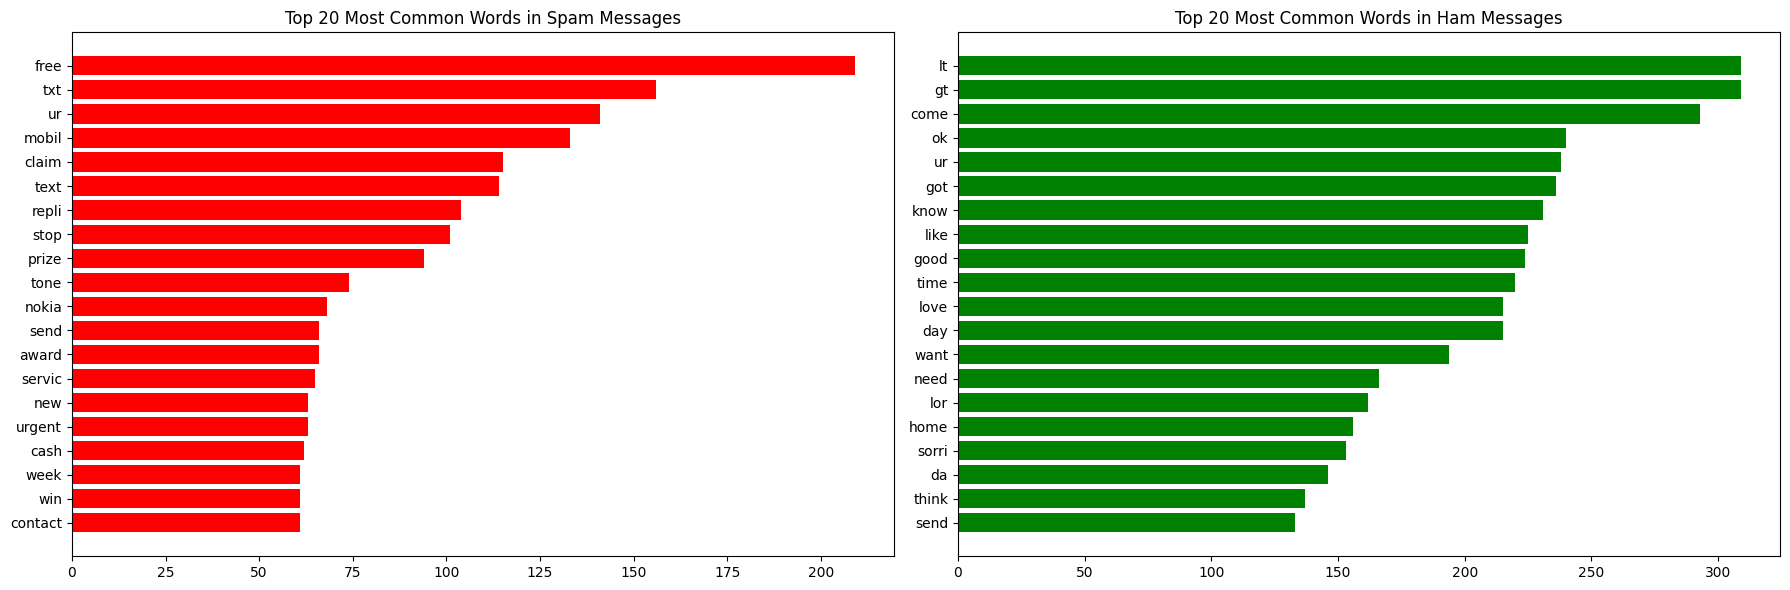

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


def extract_features(df):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(max_features=10)

    # Fit the vectorizer to the 'sms_cleaned' data and transform the data into a matrix of token counts
    X = vectorizer.fit_transform(df["sms_cleaned"])

    # This matrix 'X' can now be used as input for machine learning models
    # The following are useful attributes once CountVectorizer has been fitted:
    # Get the feature names (i.e., the vocabulary of the dataset)
    features = vectorizer.get_feature_names_out()

    # Convert the matrix to a dense matrix or DataFrame to visualize it
    dense_matrix = X.todense()
    features_df = pd.DataFrame(dense_matrix, columns=features)
    return features_df


def plot_most_common_words(df, n_top_words=20):
    """
    Plots the most common words in spam and ham messages.

    Parameters:
    - df: DataFrame with two columns, 'sms_cleaned' (text data) and 'is_spam' (boolean labels)
    - n_top_words: number of top words to plot for each category (default is 20)
    """

    # Separate the spam and ham messages
    spam_messages = df[df["is_spam"]]["sms_cleaned"]
    ham_messages = df[~df["is_spam"]]["sms_cleaned"]

    # Initialize CountVectorizers
    vectorizer_spam = CountVectorizer(stop_words="english")
    vectorizer_ham = CountVectorizer(stop_words="english")

    # Fit and transform the messages
    spam_matrix = vectorizer_spam.fit_transform(spam_messages)
    ham_matrix = vectorizer_ham.fit_transform(ham_messages)

    # Sum the count of each word for spam and ham
    sum_spam = np.sum(spam_matrix, axis=0)
    sum_ham = np.sum(ham_matrix, axis=0)

    # Convert to array and get the list of words corresponding to the columns
    words_spam = [
        (word, sum_spam[0, idx]) for word, idx in vectorizer_spam.vocabulary_.items()
    ]
    words_ham = [
        (word, sum_ham[0, idx]) for word, idx in vectorizer_ham.vocabulary_.items()
    ]

    # Sort the words based on frequency
    words_spam = sorted(words_spam, key=lambda x: x[1], reverse=True)[:n_top_words]
    words_ham = sorted(words_ham, key=lambda x: x[1], reverse=True)[:n_top_words]

    # Unzip into words and counts
    spam_words, spam_counts = zip(*words_spam)
    ham_words, ham_counts = zip(*words_ham)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Spam Words
    ax1.barh(spam_words, spam_counts, color="red")
    ax1.set_title(f"Top {n_top_words} Most Common Words in Spam Messages")
    ax1.invert_yaxis()

    # Ham Words
    ax2.barh(ham_words, ham_counts, color="green")
    ax2.set_title(f"Top {n_top_words} Most Common Words in Ham Messages")
    ax2.invert_yaxis()

    # Display plot
    plt.tight_layout()
    plt.show()


# Display the dense DataFrame
plot_most_common_words(data, n_top_words=20)

## Split Data


In [69]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

# Extract features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["sms_cleaned"])

# Define the target variable 'y'
y = df["is_spam"].astype(int)  # Make sure it is an integer type

# Split the dataset into 70% training and 30% test sets (can adjust as needed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize SMOTE instance
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data only
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class balance in the target after SMOTE
print("Class distribution in y_train_smote:", pd.Series(y_train_smote).value_counts())

Class distribution in y_train_smote: is_spam
0    3252
1    3252
Name: count, dtype: int64


## Train Models: Naive Bayes Classifier


In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Instantiate the classifier
nb_classifier = MultinomialNB()

# Train the classifier using the training data after SMOTE balancing
nb_classifier.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Naive Bayes classifier: {accuracy:.2f}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy of the Naive Bayes classifier: 0.96
Confusion Matrix:
 [[1347   48]
 [  19  192]]


Ruskanda (2019) does not recommend using only accuracy as the measure of success in these cases due to the possibility of unbalanced classes.

Instead, the precision, recall, and F1-score are more informative metrics in such scenarios.


In [71]:
# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.97      0.98      1395
        Spam       0.80      0.91      0.85       211

    accuracy                           0.96      1606
   macro avg       0.89      0.94      0.91      1606
weighted avg       0.96      0.96      0.96      1606



## Train Models: Support Vector Machine (SVM)


In [72]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Since SVM is sensitive to the scale of the features, it's often useful to scale them
# Create a pipeline that first scales the data then fits the SVM
svm_pipeline = make_pipeline(
    StandardScaler(with_mean=False), SVC(kernel="linear", random_state=42)
)

# Train the SVM model using the scaled data
svm_pipeline.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_svm = svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of the SVM classifier: {accuracy_svm:.2f}")

# Generate a confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix_svm)

# Generate a classification report
class_report_svm = classification_report(
    y_test, y_pred_svm, target_names=["Ham", "Spam"]
)
print("Classification Report:\n", class_report_svm)

Accuracy of the SVM classifier: 0.85
Confusion Matrix:
 [[1200  195]
 [  43  168]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.97      0.86      0.91      1395
        Spam       0.46      0.80      0.59       211

    accuracy                           0.85      1606
   macro avg       0.71      0.83      0.75      1606
weighted avg       0.90      0.85      0.87      1606



Initial performance of SVM was:

    Accuracy of the SVM classifier: 0.85
    Confusion Matrix:
    [[1200  195]
    [  43  168]]
    Classification Report:
                  precision    recall  f1-score   support

            Ham       0.97      0.86      0.91      1395
            Spam       0.46      0.80      0.59       211

        accuracy                           0.85      1606
      macro avg       0.71      0.83      0.75      1606
    weighted avg       0.90      0.85      0.87      1606


## Hyper Parameter Optimization — using Grid search


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Create a MultinomialNB grid search
params_nb = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}
nb_classifier = MultinomialNB()
nb_grid_search = GridSearchCV(
    nb_classifier, param_grid=params_nb, cv=5, scoring="f1_weighted"
)
nb_grid_search.fit(X_train_smote, y_train_smote)

print("Best Naive Bayes Parameters:", nb_grid_search.best_params_)
print("Best Naive Bayes Model:", nb_grid_search.best_estimator_)
print("Best CV Score:", nb_grid_search.best_score_)

# Create an SVM grid search
params_svm = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"],
    "svc__kernel": ["linear", "rbf"],
}
# We can reuse the svm_pipeline from earlier, without fitting it
svm_grid_search = GridSearchCV(
    svm_pipeline, param_grid=params_svm, cv=5, scoring="f1_weighted", n_jobs=1
)
svm_grid_search.fit(X_train_smote, y_train_smote)

print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Model:", svm_grid_search.best_estimator_)
print("Best CV Score:", svm_grid_search.best_score_)

Best Naive Bayes Parameters: {'alpha': 0.1}
Best Naive Bayes Model: MultinomialNB(alpha=0.1)
Best CV Score: 0.8695101941870785
Best SVM Parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best SVM Model: Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=10, random_state=42))])
Best CV Score: 0.9299667510765108


Best Naive Bayes Parameters: {'alpha': 0.1}
Best Naive Bayes Model: MultinomialNB(alpha=0.1)
Best CV Score: 0.8695101941870785
Best SVM Parameters: {'svc**C': 10, 'svc**gamma': 'scale', 'svc\_\_kernel': 'rbf'}
Best SVM Model: Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
('svc', SVC(C=10, random_state=42))])
Best CV Score: 0.9299667510765108


### Interpreting Results


1. **Best Naive Bayes Parameters: `{'alpha': 0.1}`**

   - This indicates that out of the different values provided for the hyperparameter `alpha` during the grid search, a value of 0.1 provided the best performance according to the scoring metric used, which is `'f1_weighted'` in this case.

2. **Best Naive Bayes Model: `MultinomialNB(alpha=0.1)`**
   - This tells us the best estimator found by the grid search. In other words, this is the Naive Bayes model instantiated with the best hyperparameters (`alpha=0.1`).
3. **Best CV Score for Naive Bayes: `0.8695101941870785`**

   - This is the best cross-validation (`CV`) score achieved by the best Naive Bayes model. The CV score is a measure of the model's performance as determined by the weighted F1-score, which is a harmonic mean of precision and recall, providing a balance between the two for each class and accounting for class imbalance by weighting the score for each class by its prevalence.

4. **Best SVM Parameters: `{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}`**

   - For the SVM model, the best parameters identified by the grid search include `C=10`, `gamma='scale'` (which means gamma is set to 1 / (number of features \* X.var()) as the kernel coefficient), and `kernel='rbf'` (radial basis function). These parameters specify how the SVM model should be configured to achieve the best performance with respect to the F1-score metric.

5. **Best SVM Model: Pipeline with `StandardScaler` and `SVC(C=10, random_state=42)`**

   - This shows us the best SVM model wrapped in a pipeline, which includes preprocessing with a `StandardScaler` and the SVM classifier. Here, `SVC(C=10)` implies the SVM model with regularization parameter `C` set to 10 and the use of a radial basis function kernel.

6. **Best CV Score for SVM: `0.9299667510765108`**
   - The best CV score for the SVM model is higher than that for the Naive Bayes model, with a value of approximately 0.93. This suggests that, based on the F1-score, the SVM model (with the specified parameters) performed better in the cross-validation process on our dataset.

**Setting Hyperparameters Based on Grid Search Results:**

- We can now set the hyperparameters of both models to the best ones identified during grid search. For the Naive Bayes model, we will use: `MultinomialNB(alpha=0.1)`.
- For the SVM model within a pipeline, we will use: `make_pipeline(StandardScaler(with_mean=False), SVC(C=10, kernel='rbf', gamma='scale', random_state=42))`.


## Train Best model


### Best Model SVC


In [74]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    SVC(C=10, kernel="rbf", gamma="scale", random_state=42),
)

# Train the SVM model using the scaled data
svm_pipeline.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_svm = svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of the SVM classifier: {accuracy_svm:.2f}")

# Generate a confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix_svm)

# Generate a classification report
class_report_svm = classification_report(
    y_test, y_pred_svm, target_names=["Ham", "Spam"]
)
print("Classification Report:\n", class_report_svm)

Accuracy of the SVM classifier: 0.87
Confusion Matrix:
 [[1265  130]
 [  79  132]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.94      0.91      0.92      1395
        Spam       0.50      0.63      0.56       211

    accuracy                           0.87      1606
   macro avg       0.72      0.77      0.74      1606
weighted avg       0.88      0.87      0.88      1606



### Best Model Naive Bayes


In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Instantiate the classifier
nb_classifier = MultinomialNB(alpha=0.1)

# Train the classifier using the training data after SMOTE balancing
nb_classifier.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Naive Bayes classifier: {accuracy:.2f}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
print("Classification Report:\n", class_report)

Accuracy of the Naive Bayes classifier: 0.97
Confusion Matrix:
 [[1357   38]
 [  18  193]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.97      0.98      1395
        Spam       0.84      0.91      0.87       211

    accuracy                           0.97      1606
   macro avg       0.91      0.94      0.93      1606
weighted avg       0.97      0.97      0.97      1606



Despite the indications from our grid search when retraining and evaluating the models it is clear that Naive Bays out performs SVC when looking at Ham and Spam scores distinctly. (Uncertain exactly why this is the case.)
Both models are improved by the selection of appropriate hyper parameters when compared to the initial attempts, however.


## Testing Models


In [79]:
import time
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Initialize dictionaries to save the evaluation metrics
metrics_nb = {}
metrics_svc = {}

# Evaluate Naive Bayes
start_train_nb = time.time()
nb_classifier.fit(
    X_train_smote, y_train_smote
)  # Fitting might be redundant if already fit previously
end_train_nb = time.time()
metrics_nb["training_time"] = end_train_nb - start_train_nb

start_pred_nb = time.time()
y_pred_nb = nb_classifier.predict(X_test)
end_pred_nb = time.time()
metrics_nb["prediction_time"] = end_pred_nb - start_pred_nb
metrics_nb["accuracy"] = accuracy_score(y_test, y_pred_nb)
metrics_nb["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred_nb)

# Print Naive Bayes metrics
print("Naive Bayes Metrics:")
for metric, value in metrics_nb.items():
    print(f"{metric}: {value:.4f}")

# Evaluate SVM
start_train_svc = time.time()
svm_pipeline.fit(X_train_smote, y_train_smote)
end_train_svc = time.time()
metrics_svc["training_time"] = end_train_svc - start_train_svc

start_pred_svc = time.time()
y_pred_svc = svm_pipeline.predict(X_test)
end_pred_svc = time.time()
metrics_svc["prediction_time"] = end_pred_svc - start_pred_svc
metrics_svc["accuracy"] = accuracy_score(y_test, y_pred_svc)
metrics_svc["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred_svc)

# Print SVM metrics
print("\nSVM Metrics:")
for metric, value in metrics_svc.items():
    print(f"{metric}: {value:.4f}")

Naive Bayes Metrics:
training_time: 0.0043
prediction_time: 0.0003
accuracy: 0.9583
balanced_accuracy: 0.9378

SVM Metrics:
training_time: 1.1697
prediction_time: 0.2258
accuracy: 0.8699
balanced_accuracy: 0.7662


## References

Kaddoura, S., Chandrasekaran, G., Popescu, D.E. and Duraisamy, J.H., 2022. A systematic literature review on spam content detection and classification. _PeerJ Computer Science_, [e-journal] 8:e830. Available at: <https://doi.org/10.7717/peerj-cs.830>

Ruskanda, F.Z., 2019. Study on the effect of preprocessing methods for spam email detection. _Indonesia Journal of Computing_, [e-journal] 4(1), MARET. Available at: <https://doi.org/10.21108/INDOJC.2019.4.1.284>
